In [1]:
%matplotlib inline
##########################################
# To use tensorflow follow instructions here: https://www.tensorflow.org/install/pip
# follow instructions related to creating a virtual environment with conda which can be the same 
# environment as ska3 here: https://github.com/sot/skare3/wiki/Ska3-runtime-environment-for-users
# ska is also needed
#########################################
import tensorflow as tf 
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from Ska.engarchive import fetch
import Chandra.Time
from kadi import events

# Pulling and Organizing Data

In [2]:
from datetime import datetime, timedelta, time

#this is a generalized function to take the time that's given by ska
#and format is as datetime
def tme(x):
    return (datetime.strptime(Chandra.Time.DateTime(x).date, '%Y:%j:%H:%M:%S.%f'))
change_time = np.vectorize(tme)

In [4]:
#here we will find the observations/time periods to use for training
#this code will most likely be used for the eq database as well
#Find observations since 2018 that have lasted 8 hours or more
dwells = events.dwells.filter(dur__gt=28800, start = '2018:001')
poss_obs = {}

#of these observations pick the ones with constant pitch
#Jean helped with best way to get constant pitch observations
for d in dwells:
    obsid = d.get_obsid()
    pitch = fetch.Msid('DP_PITCH', d.start, d.stop, stat='5min')
    poss_obs[obsid] = (np.mean(pitch.vals), d.stop, d.start)

#organizing the obs data into a useful format
obs_data = {}
for obs_id in poss_obs:
    obs = poss_obs[obs_id]
    t_form = '%Y:%j:%H:%M:%S.%f'
    start, end = datetime.strptime(obs[2], t_form), datetime.strptime(obs[1], t_form)
    dur = end-start
    obs_data[obs_id] = {'pitch': obs[0], 'start': start, 'stop': end, 'dur': dur}

df_obs = pd.DataFrame.from_dict(obs_data, orient = 'index')
#ordered = df_obs.sort_values('dur', ascending = False)

In [6]:
import itertools 
import timeit

#numpy doesn't know how to round float64, so creating a helper function
def round_vals(msid_val):
    return (round(float(msid_val), 3))
rounded = np.vectorize(round_vals)

########################################
# The purpose of the two functions below is to map the right positional
# arguments to the right timing for the MSID we're looking
# logical_intervals creates intervals of time during which an MSID
# holds a certain value and select_intervals maps these intervals 
# to the times column of the MSID
#######################################

def logical_intervals(times, values):
    i = 0
    ending = len(times)
    intervals = []
    inter_values = []
    # from the itertools documentation:
    # [k for k, g in groupby('AAAABBBCCDAABBB')] --> A B C D A B
    # [list(g) for k, g in groupby('AAAABBBCCD')] --> AAAA BBB CC D
    # itertools.groupby returns A:[A,A,A,A], B:[B,B,B], C:[C,C], D:[D]
    grouped_vals = itertools.groupby(values)
    for loc_value, group in itertools.groupby(values):
        elems = len(list(group))
        begin = times[i] if i > 0 else times[i]-3600.00
        i += elems
        end = times[i] if i < ending else times[i-1]
        intervals += [(begin, end)]
        inter_values += [loc_value]
    return (intervals, inter_values)

def select_intervals(msid_data, loc_data):
    lstart = timeit.default_timer()
    msid_loc = np.empty(len(msid_data.times))
    round_loc_data = rounded(loc_data.vals)
    print("rounded: ", timeit.default_timer() - lstart)
    intervals, inter_values = logical_intervals(loc_data.times, round_loc_data)
    print("logiced: ", timeit.default_timer()  - lstart)
    #here we are using the intervals from logic_intervals to create a datafram where the intervals are the index
    interval_dataframe = pd.DataFrame(inter_values, index = pd.IntervalIndex.from_tuples(intervals, closed = 'left'),
                                     columns = ['val'])
    #having intervals as the index allows us to do the below functioning
    #we give interval_dataframe a list of times and it returns the value attached to it
    msid_loc = interval_dataframe.loc[msid_data.times[:]]
    print ("shape:", msid_loc.shape, msid_data.times.shape)
    print("intervaled: ", timeit.default_timer() - lstart)
    return (msid_loc['val'].values)


In [7]:
#here we us the long pitch observations from before and build our data from around that time period
#we will start with average HRMA temp (4OAVHRMT)

fetch.data_source.set('cxc')
for i in range(len(df_obs[0:1])):
    obs = df_obs.iloc[i]
    start = (obs['start'] - timedelta(30)).strftime('%Y:%j:%H:%M:%S')
    stop = (obs['stop'] + timedelta(50)).strftime('%Y:%j:%H:%M:%S')
    print(start, stop)
    data = fetch.MSIDset(['4OAVHRMT', 'DP_PITCH', 'AOATTQT1', 'AOATTQT2', 'AOATTQT3', 'AOATTQT4'], start, stop)
    

2018:255:22:35:32 2018:338:23:07:45


In [8]:
#from Quaternion import Quat
from mica.quaternion import Quat, normalize
quat_vals = normalize(np.vstack([data["{}{}".format('AOATTQT',i)].vals 
                                 for i in [1,2,3,4]]).transpose())

#the below will turn the AOATTQT data and return [RA, Dec, Roll]
#TODO: change this to return yaw (we don't care about Dec and Roll)
def quatty(quarts):
    return (Quat(quarts).equatorial)
quat_vect = np.apply_along_axis(quatty, 1, quat_vals)

/scratch1/miniconda3/envs/ska3/lib/python3.6/site-packages/mica/quaternion.py:556: RuntimeWarning: invalid value encountered in true_divide
  return quat / np.sqrt(np.sum(quat * quat, axis=-1)[:, np.newaxis])


In [9]:
ra_v, dec_v, roll_v = quat_vect[:,0] , quat_vect[:,1] , quat_vect[:,2]
q_times = data['AOATTQT1'].times
roll = pd.DataFrame({'times': q_times, 'vals': roll_v})
dec = pd.DataFrame({'times': q_times, 'vals': dec_v})
ra = pd.DataFrame({'times': q_times, 'vals': ra_v})
print (roll.vals[:5])

0    250.500567
1    250.500550
2    250.500511
3    250.500505
4    250.500478
Name: vals, dtype: float64


In [11]:
hrmt, pitch = data['4OAVHRMT'], data['DP_PITCH']
#att1, att2, att3, att4 = data['AOATTQT1'], data['AOATTQT2'], data['AOATTQT3'], data['AOATTQT4']

combined_dict = {'hrmt_times': change_time(hrmt.times),
                 'hrmt_vals': hrmt.vals,
                 'pitch': select_intervals(hrmt, pitch),
                 'roll': select_intervals(hrmt, roll),
                 'dec' : select_intervals(hrmt, dec),
                 'ra' : select_intervals(hrmt, ra)
                }


rounded:  5.9795151725411415
logiced:  7.380019245669246
shape: (218692, 1) (218692,)
intervaled:  11.521424665115774
rounded:  5.89283243753016
logiced:  40.07870348636061
shape: (218692, 1) (218692,)
intervaled:  44.2410647040233
rounded:  5.872470686212182
logiced:  39.14082833752036
shape: (218692, 1) (218692,)
intervaled:  43.20507892407477
rounded:  5.890621745027602
logiced:  40.00030126236379
shape: (218692, 1) (218692,)
intervaled:  44.17942837625742


In [12]:
#take every 15th obs (we can change this)
combined_obs = pd.DataFrame(combined_dict).iloc[::15,:]
cols = ['hrmt_times', 'hrmt_vals', 'pitch', 'roll', 'dec', 'ra']
combined_obs = combined_obs[cols]
#take out any null values
combined_obs = combined_obs[(~np.isnan(combined_obs['roll'])) | (~np.isnan(combined_obs['dec'])) | (~np.isnan(combined_obs['ra']))]

# Shaping Data

In [15]:
#reshape the data into time arrays so it looks like [val(t-n), pitch(t-n), roll(t-n),..., val(t), pitch(t)]
#we can choose and play around with n
#https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
#assumes order by time
def reshape_to_multi_time(data, frames=1):
    col_names = data.columns.values
    #df = pd.DataFrame(data)
    cols, names = list(), list()
    #input sequence (t-n, ... t-1)
    for i in range(frames, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (name,  i)) for name in col_names]
    #forecast sequence (t, t+1, ... t+n)
    for i in range(0,1):
        cols.append(data.shift(-i))
        if i == 0: 
            names += [('%s(t)' % (name)) for name in col_names]
        else:
            names += [('%s(t+%d)' % (name, i)) for name in col_names]
    #put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    #drops rows with NaN values
    agg_full = agg.dropna()
    return agg_full

from sklearn.preprocessing import MinMaxScaler

#drop time - we have uneven time frames...
#not sure how this will affect the algorithm but when refining will take a look
hrmt_times = combined_obs['hrmt_times']
raw = combined_obs.drop('hrmt_times', axis = 1)

#normalize data (to be between 0 and 1) and then reshape 
scaler = MinMaxScaler()
scaled = scaler.fit_transform(raw)
print (scaled.shape)
scaled_df = pd.DataFrame(scaled, columns = raw.columns)
frames = 8
dat = reshape_to_multi_time(scaled_df, frames=frames)
print(dat[:1])
#we drop these values since we're not predicting them 
shaped = dat.drop(["pitch(t)", "roll(t)", 'ra(t)', 'dec(t)'], axis = 1).values
print (shaped[:1])

(14576, 5)
   hrmt_vals(t-8)  pitch(t-8)  roll(t-8)  dec(t-8)   ra(t-8)  hrmt_vals(t-7)  \
8        0.138225    0.826625    0.69632  0.531565  0.905266        0.138225   

   pitch(t-7)  roll(t-7)  dec(t-7)  ra(t-7)    ...     hrmt_vals(t-1)  \
8    0.826593    0.69632  0.531506  0.90526    ...           0.138225   

   pitch(t-1)  roll(t-1)  dec(t-1)   ra(t-1)  hrmt_vals(t)  pitch(t)  roll(t)  \
8    0.826437   0.696323  0.531529  0.905279      0.143547  0.826406  0.69632   

     dec(t)     ra(t)  
8  0.531512  0.905271  

[1 rows x 45 columns]
[[0.13822497 0.82662469 0.69631985 0.53156457 0.90526559 0.13822497
  0.82659343 0.69631985 0.5315058  0.90526003 0.13822497 0.82660906
  0.69631985 0.53155281 0.90528782 0.13822497 0.82651531 0.69632263
  0.53151756 0.90525169 0.14354725 0.82651531 0.69632263 0.53154694
  0.90527392 0.13822497 0.82649968 0.69632263 0.53151168 0.9052767
  0.13822497 0.82640593 0.69632263 0.53154694 0.90525447 0.13822497
  0.82643718 0.69632263 0.53152931 0.905

In [19]:
#split into train, validation and test sets
split_size = int(shaped.shape[0]/4.0)
train = shaped[:split_size*2, :]
validate = shaped[split_size*2:split_size*3, :]
test = shaped[split_size*3: , :]
print(test.shape, train.shape, validate.shape, shaped.shape)

#because we removed null columns we want to ignore first couple of rows,
#this is important when we are transforming back, not so much here
time_split = test.shape[0]
begin_split = hrmt_times.shape[0] - time_split
time_train = hrmt_times[begin_split:split_size+begin_split]
time_test = hrmt_times[-time_split:]
print (time_test.shape)

#split into inputs and outputs
n_features = 5
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
validate_X, validate_y = validate[:, :-1], validate[:, -1]

# reshape input to be 3D tensor with shape (samples, timesteps, features]
print (train_X.shape, train_y.shape, test_X.shape, test_y.shape)
train_X = train_X.reshape((train_X.shape[0], frames, n_features))
test_X = test_X.reshape((test_X.shape[0], frames, n_features))
validate_X = validate_X.reshape((validate_X.shape[0], frames, n_features))
print (train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print (train_X[1])

(3642, 41) (7284, 41) (3642, 41) (14568, 41)
(3642,)
(7284, 40) (7284,) (3642, 40) (3642,)
(7284, 8, 5) (7284,) (3642, 8, 5) (3642,)
[[0.13822497 0.82659343 0.69631985 0.5315058  0.90526003]
 [0.13822497 0.82660906 0.69631985 0.53155281 0.90528782]
 [0.13822497 0.82651531 0.69632263 0.53151756 0.90525169]
 [0.14354725 0.82651531 0.69632263 0.53154694 0.90527392]
 [0.13822497 0.82649968 0.69632263 0.53151168 0.9052767 ]
 [0.13822497 0.82640593 0.69632263 0.53154694 0.90525447]
 [0.13822497 0.82643718 0.69632263 0.53152931 0.90527948]
 [0.14354725 0.82640593 0.69631985 0.53151168 0.90527114]]


# Modeling and Validation

In [35]:
#from keras.models import Sequential
#from keras.layers import LSTM
import tensorflow as tf
from tensorflow.keras import layers, callbacks


#design network
timesteps, data_dim = train_X.shape[1], train_X.shape[2]
model = tf.keras.Sequential()
model.add(layers.LSTM(32, input_shape = (timesteps, data_dim), activation = 'sigmoid'))
#model.add(layers.LSTM(32, return_sequences = True))
#model.add(layers.LSTM(16))
model.add(layers.Dense(1))
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])
print (model.summary())

#fit network
epochs = 200
batch_size = 512
#checkpoint saves the best model in a file that we load later
checkpoint_path = 'saved_models/weights_best'
checkpointer = callbacks.ModelCheckpoint(filepath= checkpoint_path,
                                        verbose = 1, save_best_only = True, mode = 'min')

history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, 
                    validation_data=(validate_X, validate_y), verbose=2, shuffle=False,
                   callbacks=[checkpointer])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________
None
Train on 7284 samples, validate on 3642 samples
Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.12507, saving model to saved_models/weights_best
 - 2s - loss: 0.1705 - acc: 0.0037 - val_loss: 0.1251 - val_acc: 0.0000e+00
Epoch 2/200

Epoch 00002: val_loss did not improve from 0.12507
 - 0s - loss: 0.2148 - acc: 0.0037 - val_loss: 0.2216 - val_acc: 0.0000e+00
Epoch 3/200

Epoch 00003: val_loss did not improve from 0.12507
 - 0s - loss: 0.1670 - acc: 0.0037 - val_loss: 0.1351 - val_acc: 0.0000e+00
Epoch 4/200

Epoch 0

Epoch 46/200

Epoch 00046: val_loss improved from 0.02934 to 0.02582, saving model to saved_models/weights_best
 - 0s - loss: 0.0559 - acc: 0.0052 - val_loss: 0.0258 - val_acc: 0.0000e+00
Epoch 47/200

Epoch 00047: val_loss did not improve from 0.02582
 - 0s - loss: 0.0531 - acc: 0.0052 - val_loss: 0.0354 - val_acc: 0.0000e+00
Epoch 48/200

Epoch 00048: val_loss did not improve from 0.02582
 - 0s - loss: 0.0527 - acc: 0.0052 - val_loss: 0.0459 - val_acc: 0.0000e+00
Epoch 49/200

Epoch 00049: val_loss did not improve from 0.02582
 - 0s - loss: 0.0533 - acc: 0.0052 - val_loss: 0.0313 - val_acc: 0.0000e+00
Epoch 50/200

Epoch 00050: val_loss did not improve from 0.02582
 - 0s - loss: 0.0410 - acc: 0.0052 - val_loss: 0.0323 - val_acc: 0.0000e+00
Epoch 51/200

Epoch 00051: val_loss did not improve from 0.02582
 - 0s - loss: 0.0356 - acc: 0.0052 - val_loss: 0.0364 - val_acc: 0.0000e+00
Epoch 52/200

Epoch 00052: val_loss did not improve from 0.02582
 - 0s - loss: 0.0316 - acc: 0.0052 - val_l

Epoch 102/200

Epoch 00102: val_loss did not improve from 0.00346
 - 0s - loss: 0.0149 - acc: 0.0052 - val_loss: 0.0222 - val_acc: 0.0000e+00
Epoch 103/200

Epoch 00103: val_loss did not improve from 0.00346
 - 0s - loss: 0.0138 - acc: 0.0052 - val_loss: 0.0046 - val_acc: 0.0000e+00
Epoch 104/200

Epoch 00104: val_loss did not improve from 0.00346
 - 0s - loss: 0.0056 - acc: 0.0052 - val_loss: 0.0082 - val_acc: 0.0000e+00
Epoch 105/200

Epoch 00105: val_loss did not improve from 0.00346
 - 0s - loss: 0.0061 - acc: 0.0052 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 106/200

Epoch 00106: val_loss did not improve from 0.00346
 - 0s - loss: 0.0049 - acc: 0.0052 - val_loss: 0.0085 - val_acc: 0.0000e+00
Epoch 107/200

Epoch 00107: val_loss did not improve from 0.00346
 - 0s - loss: 0.0058 - acc: 0.0052 - val_loss: 0.0074 - val_acc: 0.0000e+00
Epoch 108/200

Epoch 00108: val_loss did not improve from 0.00346
 - 0s - loss: 0.0061 - acc: 0.0052 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 

Epoch 160/200

Epoch 00160: val_loss did not improve from 0.00346
 - 0s - loss: 0.0110 - acc: 0.0052 - val_loss: 0.0370 - val_acc: 0.0000e+00
Epoch 161/200

Epoch 00161: val_loss did not improve from 0.00346
 - 0s - loss: 0.0189 - acc: 0.0052 - val_loss: 0.0053 - val_acc: 0.0000e+00
Epoch 162/200

Epoch 00162: val_loss did not improve from 0.00346
 - 0s - loss: 0.0143 - acc: 0.0052 - val_loss: 0.0143 - val_acc: 0.0000e+00
Epoch 163/200

Epoch 00163: val_loss did not improve from 0.00346
 - 0s - loss: 0.0093 - acc: 0.0052 - val_loss: 0.0060 - val_acc: 0.0000e+00
Epoch 164/200

Epoch 00164: val_loss did not improve from 0.00346
 - 0s - loss: 0.0056 - acc: 0.0052 - val_loss: 0.0038 - val_acc: 0.0000e+00
Epoch 165/200

Epoch 00165: val_loss did not improve from 0.00346
 - 0s - loss: 0.0089 - acc: 0.0052 - val_loss: 0.0090 - val_acc: 0.0000e+00
Epoch 166/200

Epoch 00166: val_loss did not improve from 0.00346
 - 0s - loss: 0.0100 - acc: 0.0052 - val_loss: 0.0178 - val_acc: 0.0000e+00
Epoch 

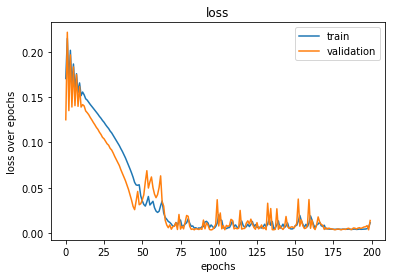

In [37]:
#plot our validation loss over epochs
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss over epochs')
plt.legend()
plt.show()

In [32]:
#load the best model from our checkpoint
model.load_weights(checkpoint_path)

from sklearn.metrics import mean_squared_error
#use the above model to predict on our test set 
yhat = model.predict(test_X)
print("Test X shape:", test_X.shape)

#here we are converting back to our original [var1(t-2), var2(t-2), var1(t-1), var2(t-1)] shape
test_X1 = test_X.reshape((test_X.shape[0], timesteps*data_dim))
print("Test X1 shape:", test_X1.shape)
#number of predictive variables
p_var = n_features -1
#invert scaling from 0 to 1 for forecast
#here we need to return to our original form of hrma_temp(predicted) and pitch(actual)
inv_yhat = np.concatenate((yhat, test_X1[:,-p_var:]), axis = 1)
inv_yhat1 = scaler.inverse_transform(inv_yhat)
inv_ypred = inv_yhat1[:,0]

#invert scaling from 0 to 1 for 
test_y1 = test_y.reshape((len(test_y), 1))
#here we return to our original form of hrma_temp(actual) and pitch(actual)
inv_y = np.concatenate((test_y1, test_X1[:,-p_var:]), axis = 1)
inv_y1 = scaler.inverse_transform(inv_y)
inv_yactual= inv_y1[:,0]
rmse = np.sqrt(mean_squared_error(inv_yactual, inv_ypred))
#here I'm using Mean Squared Error but obvi we can change this
print('Test RMSE: %.3f' % rmse)

Test X shape: (3642, 8, 5)
Test X1 shape: (3642, 40)
Test RMSE: 0.010


In [33]:
#here we will plot all graphs
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import DatetimeTickFormatter
output_notebook()
p = figure(title = 'Predicted vs Actual', x_axis_label = 'time', 
           y_axis_label = 'temp', x_axis_type = "datetime")
#plot actual and predicted temperature vs. time
#p.circle(time_test, inv_yactual, legend="actual")
p.circle(time_test, inv_ypred, legend="predicted", color = 'red')
p.circle(combined_obs.hrmt_times, combined_obs.hrmt_vals, legend = 'original', color = 'green', fill_alpha = 0.2, line_width = 0.01)
p.xaxis.formatter = DatetimeTickFormatter(
                                minutes = ["%Y:%j:%H:%M"],
                                hours = ["%Y:%j:%H"],
                                hourmin = ["%Y:%j:%H:%M"],
                                days = ["%Y:%j"]
                        )

show(p)

Loading BokehJS ...

In [ ]:
'''def logical_intervals_old(times, values):
    print (values[:5])
    i = 0
    ending = len(times)
    intervals = []
    # [k for k, g in groupby('AAAABBBCCDAABBB')] --> A B C D A B
    # [list(g) for k, g in groupby('AAAABBBCCD')] --> AAAA BBB CC D
    #itertools.groupby returns A:[A,A,A,A], B:[B,B,B], C:[C,C], D:[D]
    start = timeit.default_timer()
    print("logic start:", start)
    grouped_vals = itertools.groupby(values)
    print("grouped: ", timeit.default_timer() - start)
    for loc_value, group in itertools.groupby(values):
        elems = len(list(group))
        begin = times[i] if i > 0 else times[i]-3600.00
        i += elems
        end = times[i] if i < ending else times[i-1]
        intervals += [(loc_value, begin, end)]
    print("done loop: ", timeit.default_timer() - start)
    return (intervals)


def select_intervals_old(msid_data, loc_data):
    lstart = timeit.default_timer()
    print("select start:", lstart)
    msid_loc = np.empty(len(msid_data.times))
    round_loc_data = rounded(loc_data.vals)
    print("rounded: ", timeit.default_timer() - lstart)
    intervals = logical_intervals_old(loc_data.times, round_loc_data)
    print("logiced: ", timeit.default_timer()  - lstart)
    for interval in intervals:
        begin, end = interval[1], interval[2]
        msid_bool = ((msid_data.times >= begin) & (msid_data.times <= end))
        msid_loc[msid_bool] = interval[0]
    print("intervaled: ", timeit.default_timer() - lstart)
    return (msid_loc)'''